<a href="https://colab.research.google.com/github/sherryfish321/titanic-survival-prediction/blob/main/Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c titanic
!unzip titanic.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  titanic.zip
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: gender_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y'
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn


In [57]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [58]:
train.info()
train.describe()
train['Survived'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,proportion
Survived,
0,0.616162
1,0.383838


<Axes: xlabel='Sex', ylabel='Survived'>

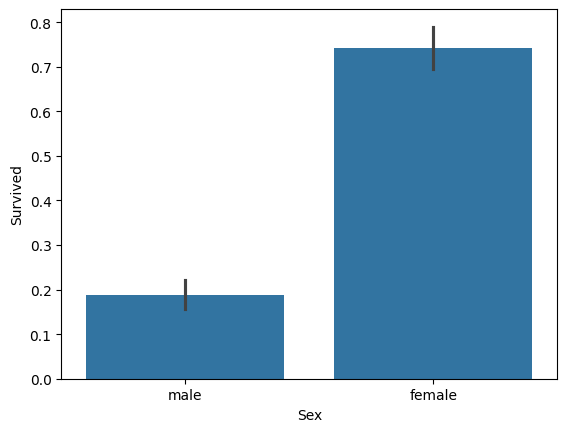

In [ ]:
import seaborn as sns
sns.barplot(x="Sex", y="Survived", data=train)

<Axes: xlabel='Pclass', ylabel='Survived'>

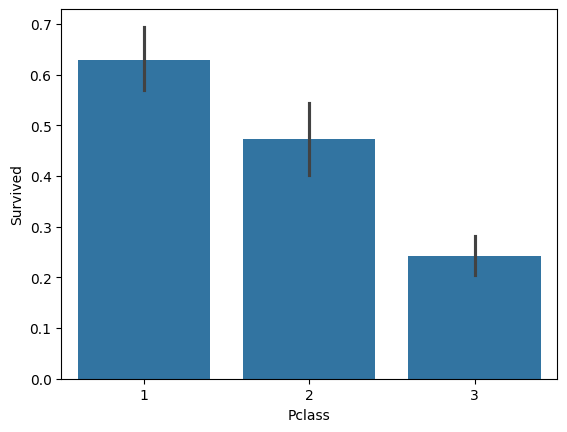

In [ ]:
sns.barplot(x="Pclass", y="Survived", data=train)

<Axes: xlabel='Age', ylabel='Count'>

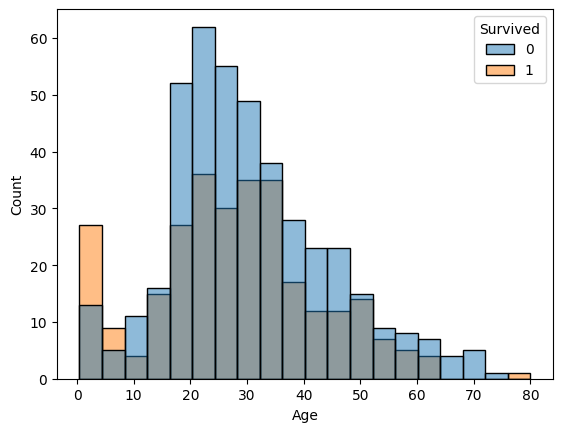

In [ ]:
sns.histplot(data=train, x="Age", bins=20, hue="Survived")

<Axes: xlabel='Embarked', ylabel='Survived'>

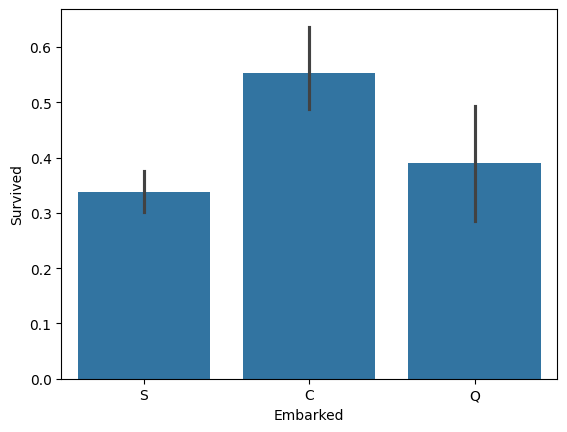

In [ ]:
sns.barplot(data=train, x="Embarked", y="Survived")

<Axes: xlabel='SibSp', ylabel='Survived'>

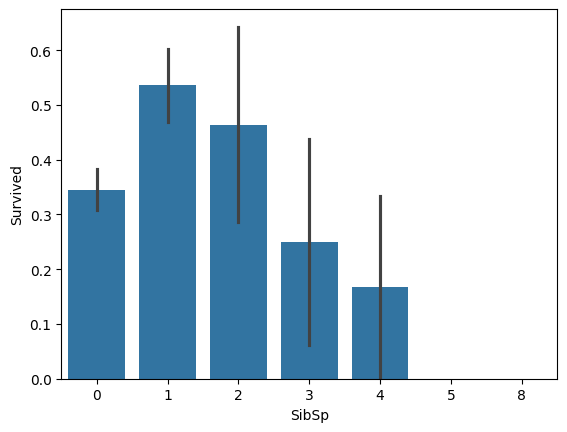

In [ ]:
sns.barplot(data=train, x="SibSp", y="Survived")

<Axes: xlabel='Parch', ylabel='Survived'>

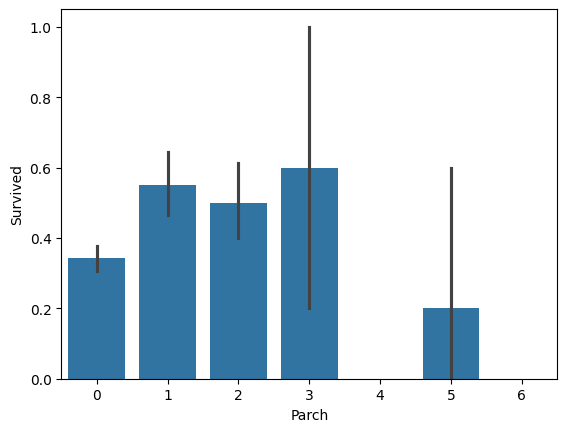

In [ ]:
sns.barplot(data=train, x="Parch", y="Survived")

In [59]:
def na_report(df, name="df"):
    print(f"[{name}] shape={df.shape}")
    rep = df.isna().sum().sort_values(ascending=False)
    rep = rep[rep>0]
    if rep.empty:
        print("No missing values.")
    else:
        display(rep.to_frame("n_missing").assign(ratio=lambda x: x["n_missing"]/len(df)))

na_report(train, "train")
na_report(test,  "test")


[train] shape=(891, 12)


,n_missing,ratio
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


[test] shape=(418, 11)


,n_missing,ratio
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392


In [60]:
import numpy as np

for df in (train, test):
    df["Title"] = df["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)

# Merge rare titles
rare_map = {
    "Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs",
    "Lady":"Royal", "Countess":"Royal", "Sir":"Royal", "Don":"Royal", "Jonkheer":"Royal",
    "Capt":"Officer", "Col":"Officer", "Major":"Officer", "Dr":"Officer", "Rev":"Officer"
}
for df in (train, test):
    df["Title"] = df["Title"].replace(rare_map)


In [61]:
# Embarked：Impute the missing values in the training set with the mode (apply only to train; test set has almost no missing values).

emb_mode = train["Embarked"].mode()[0]
train["Embarked"] = train["Embarked"].fillna(emb_mode)

# Fare：Impute missing values in each dataset using the respective median (common for test data).
train["Fare"] = train["Fare"].fillna(train["Fare"].median())
test["Fare"]  = test["Fare"].fillna(test["Fare"].median())


In [62]:
# To ensure consistency between the train and test sets, the median is computed on the combined data and then used to impute missing values in each dataset separately.
comb = pd.concat([train[["Age","Pclass","Sex","Title"]],
                  test[["Age","Pclass","Sex","Title"]]], axis=0, ignore_index=True)

age_median_table = comb.groupby(["Pclass","Sex","Title"])["Age"].median()

def fill_age(row):
    if pd.isna(row["Age"]):
        key = (row["Pclass"], row["Sex"], row["Title"])
        if key in age_median_table:
            return age_median_table.loc[key]
    return row["Age"]

for df in (train, test):
    df["Age"] = df.apply(fill_age, axis=1)

# If a small number of values remain uncovered, they are imputed using the overall median as a fallback.
for df in (train, test):
    df["Age"] = df["Age"].fillna(df["Age"].median())


In [63]:
for df in (train, test):
    df["Deck"] = df["Cabin"].str[0]      # Take the first letter: A/B/C/…/NaN.
    df["Deck"] = df["Deck"].fillna("U")  # Unknown
    df.drop(columns=["Cabin"], inplace=True)


In [64]:
na_report(train, "train_after")
na_report(test,  "test_after")


[train_after] shape=(891, 13)
No missing values.
[test_after] shape=(418, 12)
No missing values.


In [65]:
# Basic cleaning: retain PassengerId for later use in generating the submission file.
test_passenger_id = test["PassengerId"].copy()

# Categorical features are encoded using one-hot encoding; although the Sex variable could alternatively be mapped to 0/1, one-hot encoding is applied for consistency.
categoricals = ["Sex", "Embarked", "Title", "Deck", "Pclass"]
train_enc = pd.get_dummies(train.drop(columns=["Name","Ticket"]), columns=categoricals, drop_first=False)
test_enc  = pd.get_dummies(test.drop(columns=["Name","Ticket"]),  columns=categoricals, drop_first=False)

# Align the feature columns to avoid categories that appear only in the train or test set.
train_enc, test_enc = train_enc.align(test_enc, join="left", axis=1, fill_value=0)

# Separate features and labels.
y = train_enc["Survived"].copy()
X = train_enc.drop(columns=["Survived"])

# the features of the test set (excluding Survived)
X_test = test_enc.drop(columns=["Survived"], errors="ignore")

# Finally, a verification step is performed to ensure no missing values remain.
assert X.isna().sum().sum() == 0
assert X_test.isna().sum().sum() == 0


In [66]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

In [67]:
train["IsAlone"] = 0
train.loc[train["FamilySize"] == 1, "IsAlone"] = 1

test["IsAlone"] = 0
test.loc[test["FamilySize"] == 1, "IsAlone"] = 1

In [68]:
train["AgeBin"] = pd.cut(train["Age"], bins=[0, 12, 18, 35, 60, 80], labels=[0,1,2,3,4])
test["AgeBin"] = pd.cut(test["Age"], bins=[0, 12, 18, 35, 60, 80], labels=[0,1,2,3,4])

In [69]:
train["FareBin"] = pd.qcut(train["Fare"], 4, labels=[0,1,2,3])
test["FareBin"] = pd.qcut(test["Fare"], 4, labels=[0,1,2,3])

In [70]:
train = pd.get_dummies(train, columns=["Embarked"], drop_first=True)
test = pd.get_dummies(test, columns=["Embarked"], drop_first=True)

In [92]:
# drop_cols = ["PassengerId", "Name", "Ticket", "Cabin"]
# train.drop(columns=drop_cols, inplace=True, errors="ignore")
# test_passengerId = test["PassengerId"]
# test.drop(columns=drop_cols, inplace=True, errors="ignore")

# Check the inspect feature
print(train.head())


   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Title  FamilySize  \
0         0       3    0  22.0      1      0   7.2500    0.0           2   
1         1       1    1  38.0      1      0  71.2833    2.0           2   
2         1       3    1  26.0      0      0   7.9250    1.0           1   
3         1       1    1  35.0      1      0  53.1000    2.0           2   
4         0       3    0  35.0      0      0   8.0500    0.0           1   

   IsAlone AgeBin FareBin  Embarked_Q  Embarked_S  
0        0      2       0       False        True  
1        0      3       3       False       False  
2        1      2       1       False        True  
3        0      2       3       False        True  
4        1      2       1       False        True  


In [76]:
sex_map = {"male": 0, "female": 1}
train["Sex"] = train["Sex"].map(sex_map)
test["Sex"]  = test["Sex"].map(sex_map)


In [82]:
title_mapping = {
    "Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3,
    "Dr": 4, "Rev": 5, "Col": 6, "Major": 6, "Mlle": 1,
    "Countess": 7, "Ms": 1, "Lady": 7, "Jonkheer": 7,
    "Don": 7, "Dona": 7, "Mme": 2, "Capt": 6, "Sir": 7
}
train["Title"] = train["Title"].map(title_mapping)
test["Title"] = test["Title"].map(title_mapping)
train["Title"] = train["Title"].fillna(0)
test["Title"] = test["Title"].fillna(0)


In [88]:
train.drop(columns=["Deck"], inplace=True, errors="ignore")
test.drop(columns=["Deck"],  inplace=True, errors="ignore")

In [84]:
X = train.drop("Survived", axis=1)
non_numeric = X.select_dtypes(include=["object"]).columns
print("非數值欄位:", non_numeric)


非數值欄位: Index([], dtype='object')


In [90]:
# 1) Redefine the feature matrix X and the target vector y.
X = train.drop("Survived", axis=1)
y = train["Survived"]

# 2) No column is allowed to contain NaN values.
assert X.isnull().sum().sum() == 0, "X 仍有缺失值"
assert test.isnull().sum().sum() == 0, "test 仍有缺失值"

# 3) No column is allowed to have the object data type.
assert len(X.select_dtypes(include=["object"]).columns) == 0, "X 仍有字串欄位"
assert len(test.select_dtypes(include=["object"]).columns) == 0, "test 仍有字串欄位"


In [98]:
from sklearn.model_selection import train_test_split

# Features and target
X = train.drop("Survived", axis=1)
y = train["Survived"]

# Split into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [99]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [100]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [102]:
import pandas as pd

# Convert categorical columns into integer codes, with NaN values encoded as -1.
for df in [train, test]:
    for col in ["AgeBin", "FareBin"]:
        if pd.api.types.is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes

# Redefine X and y, and then perform the split.
from sklearn.model_selection import train_test_split
X = train.drop("Survived", axis=1)
y = train["Survived"]

# Strict validation: no object types and no NaN values are allowed.
assert len(X.select_dtypes(include=["object"]).columns) == 0
assert X.isnull().sum().sum() == 0 and test.isnull().sum().sum() == 0

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train XGBoost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss"
)
xgb_model.fit(X_train, y_train)


/tmp/ipython-input-1546859016.py:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col]):


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [103]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

y_pred = xgb_model.predict(X_val)
y_proba = xgb_model.predict_proba(X_val)[:, 1]

print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# Generate submission.csv
final_model = xgb_model
final_model.fit(X, y)  # The final model is trained on the full training data

test_pred = final_model.predict(test)
submission = pd.DataFrame({"PassengerId": test_passengerId, "Survived": test_pred})
submission.to_csv("submission.csv", index=False)


Accuracy: 0.8212290502793296
ROC-AUC: 0.8492753623188405
Confusion Matrix:
 [[96 14]
 [18 51]]


In [104]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

models = {
    "Logistic Regression": log_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

for name, model in models.items():
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    print(f"🔹 {name}")
    print(f"   Accuracy: {acc:.4f}, ROC-AUC: {roc:.4f}")
    print(f"   Confusion Matrix:\n{cm}\n")


🔹 Logistic Regression
   Accuracy: 0.8547, ROC-AUC: 0.8413
   Confusion Matrix:
[[99 11]
 [15 54]]

🔹 Random Forest
   Accuracy: 0.8045, ROC-AUC: 0.7896
   Confusion Matrix:
[[94 16]
 [19 50]]

🔹 XGBoost
   Accuracy: 0.9106, ROC-AUC: 0.9057
   Confusion Matrix:
[[102   8]
 [  8  61]]



In [105]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0]
}

grid = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False, eval_metric="logloss", random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("最佳參數:", grid.best_params_)
print("最佳 ROC-AUC:", grid.best_score_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
最佳參數: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
最佳 ROC-AUC: 0.8784010560146923


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:04:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [107]:
from sklearn.model_selection import train_test_split

X_tr, X_ev, y_tr, y_ev = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [109]:
from xgboost import XGBClassifier

best_params = {
    "colsample_bytree": 0.8,
    "learning_rate": 0.05,
    "max_depth": 3,
    "n_estimators": 200,
    "subsample": 0.8,
    "random_state": 42,
    "eval_metric": "logloss"
}

final_model = XGBClassifier(**best_params)
final_model.fit(X, y)

test_pred = final_model.predict(test)
submission = pd.DataFrame({"PassengerId": test_passengerId, "Survived": test_pred})
submission.to_csv("submission.csv", index=False)
print("submission.csv 已輸出")


submission.csv 已輸出


# Task
Explain the error in the selected code, fix it, and incorporate the changes into the existing code.

## Consolidate feature engineering and encoding

### Subtask:
Apply all feature engineering and encoding steps to the original `train` and `test` dataframes to ensure consistency before splitting the data.


**Reasoning**:
Apply all the feature engineering and encoding steps to the original train and test dataframes as per the instructions to prepare them for model training.



**Reasoning**:
The error indicates that the 'Embarked' column is not found in the dataframe. This is likely because it was already one-hot encoded in a previous step. I need to remove the previous one-hot encoding of 'Embarked' and 'Pclass' before applying the consolidated one-hot encoding. I also need to drop the "PassengerId", "Name", "Ticket", and "Cabin" columns as planned in a previous cell.

